In [101]:
from __future__ import print_function
from six.moves import range

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances,cosine_distances
import time
import sys
import warnings
import os
import pickle
import pandas as pd
import PIL
from tqdm import tqdm_notebook
from keras.applications.inception_v3 import preprocess_input
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from miscc.config import cfg, cfg_from_file
from PIL import Image
import datetime
import dateutil.tz
from datasets import TextDataset
from miscc.utils import mkdir_p
from miscc.utils import build_super_images, build_super_images2
from miscc.utils import weights_init, load_params, copy_G_params
from model import G_DCGAN, G_NET
from datasets import prepare_data
from model import TEXT_TRANSFORMER_ENCODERv2, CNN_ENCODER
# from InceptionScore import calculate_inception_score
from miscc.losses import words_loss
from miscc.losses import discriminator_loss, generator_loss, KL_loss
import torchvision.transforms as transforms
from scipy.linalg import sqrtm

In [2]:
with open('../data/cifar/cifar_labels.pickle','rb') as f:
    cifar_mapping = pickle.load(f)
clabel_texts = cifar_mapping['coarse_label']
mlabel_texts = cifar_mapping['mapping']

In [3]:
# def cosine_similarity(x1, x2, dim=1, eps=1e-8):
#     """Returns cosine similarity between x1 and x2, computed along dim.
#     """
#     w12 = np.sum(x1 * x2, dim)
#     w1 = np.linalg.norm(x1, 2, dim)
#     w2 = np.linalg.norm(x2, 2, dim)
#     return (w12 / np.clip(w1 * w2,a_min=eps,a_max=1e8)).squeeze()

In [4]:
class parse_args():
    cfg_file='../code/cfg/coco_attn2.yml'
    gpu_id=0
    data_dir='../data/coco/'
    manualSeed=1
args = parse_args()

In [5]:
def w2i(w=''):
    return [i for i, val in enumerate(np.array(clabel_texts)==w) if val]
def id2imgidx(i=0):
    return [i for i, val in enumerate(y_test==i) if val]
def fid(act1,act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [6]:
args = parse_args()
if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)

if args.gpu_id == -1:
    cfg.CUDA = False
else:
    cfg.GPU_ID = args.gpu_id

if args.data_dir != '':
    cfg.DATA_DIR = args.data_dir
    

print('Using config:')
display(cfg)

split_dir, bshuffle = 'train', True
if not cfg.TRAIN.FLAG:
    # bshuffle = False
    split_dir = 'test'

Using config:


{'DATASET_NAME': 'coco',
 'CONFIG_NAME': 'glu-gan2',
 'DATA_DIR': '../data/coco/',
 'GPU_ID': 0,
 'CUDA': True,
 'WORKERS': 4,
 'RNN_TYPE': 'LSTM',
 'B_VALIDATION': False,
 'TREE': {'BRANCH_NUM': 3, 'BASE_SIZE': 64},
 'TRAIN': {'BATCH_SIZE': 14,
  'MAX_EPOCH': 130,
  'SNAPSHOT_INTERVAL': 2,
  'DISCRIMINATOR_LR': 0.0002,
  'GENERATOR_LR': 0.0002,
  'ENCODER_LR': 0.0002,
  'RNN_GRAD_CLIP': 0.25,
  'FLAG': True,
  'NET_E': '../DAMSMencoders/coco/text_encoder240.pth',
  'NET_G': '../output/coco_glu-gan2_2020_10_13_23_16_32/Model/netG_epoch_120.pth',
  'B_NET_D': True,
  'SMOOTH': {'GAMMA1': 4.0, 'GAMMA3': 10.0, 'GAMMA2': 5.0, 'LAMBDA': 50.0}},
 'GAN': {'DF_DIM': 96,
  'GF_DIM': 48,
  'Z_DIM': 100,
  'CONDITION_DIM': 100,
  'R_NUM': 3,
  'B_ATTENTION': True,
  'B_DCGAN': False},
 'TEXT': {'CAPTIONS_PER_IMAGE': 5, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 15}}

In [281]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
imsize*76/64

304.0

In [7]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM - 1))
image_transform = transforms.Compose([
    transforms.Scale(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
dataset = TextDataset(cfg.DATA_DIR, split_dir,
                      base_size=cfg.TREE.BASE_SIZE,
                      transform=image_transform)
assert dataset

Load filenames from: ../data/coco//train/filenames.pickle (82783)
Load filenames from: ../data/coco//test/filenames.pickle (40470)
Load from:  ../data/coco/captions.pickle
../data/coco/train


In [8]:
if cfg.TRAIN.NET_G == '':
    print('Error: the path for generator models is not found!')
else:
    
    # Build and load the generator
    if cfg.GAN.B_DCGAN:
        netG = G_DCGAN()
    else:
        netG = G_NET()
    netG.apply(weights_init)
    netG.cuda()
    netG.eval()
    #
    text_encoder = TEXT_TRANSFORMER_ENCODERv2(emb=cfg.TEXT.EMBEDDING_DIM
                                    ,heads=8
                                    ,depth=1
                                    ,seq_length=cfg.TEXT.WORDS_NUM
                                    ,num_tokens=dataset.n_words)
    state_dict = \
        torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)
    text_encoder.load_state_dict(state_dict)
    print('Load text encoder from:', cfg.TRAIN.NET_E)
    text_encoder = text_encoder.cuda()
    text_encoder.eval()

    image_encoder = CNN_ENCODER(cfg.TEXT.EMBEDDING_DIM)
    img_encoder_path = cfg.TRAIN.NET_E.replace('text_encoder', 'image_encoder')
    state_dict = \
        torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
    image_encoder.load_state_dict(state_dict)
    for p in image_encoder.parameters():
        p.requires_grad = False
    print('Load image encoder from:', img_encoder_path)
    image_encoder.eval()


Load text encoder from: ../DAMSMencoders/coco/text_encoder240.pth
Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Load image encoder from: ../DAMSMencoders/coco/image_encoder240.pth


In [9]:
from keras.datasets import cifar100

In [43]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [358]:
selected_id = w2i('aquarium_fish')[0]
ids = id2imgidx(selected_id)

In [359]:
# imgs = []
# for im in x_test[ids]:
#     imgs.append(np.asarray(Image.fromarray(im).resize((299,299),PIL.Image.ANTIALIAS),dtype=np.float32))
# imgs = np.array(imgs)

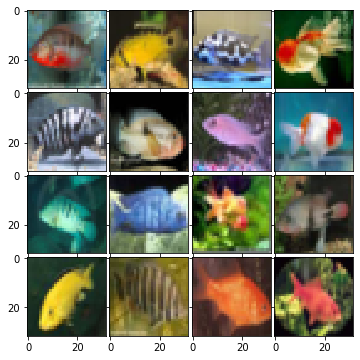

aquarium_fish


In [360]:


im1 = np.arange(100).reshape((10, 10))
im2 = im1.T
im3 = np.flipud(im1)
im4 = np.fliplr(im2)

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
         )

for ax, im in zip(grid, x_test[ids][:16]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()
print(clabel_texts[selected_id])

In [47]:
imgs = preprocess_input(x_test[ids])

In [48]:
imgs.min(),imgs.max()

(-1.0, 1.0)

In [49]:
print(imgs.shape)
i = np.rollaxis(imgs,axis=3,start=1)
i = np.asarray(i,dtype=np.float32)
print(i.shape)

(100, 32, 32, 3)
(100, 3, 32, 32)


In [50]:
img_inp = torch.tensor(i)

In [51]:
r_emb, i_emb = image_encoder(img_inp)

In [52]:
r_emb.shape,i_emb.shape

(torch.Size([100, 256, 17, 17]), torch.Size([100, 256]))

In [53]:
i_emb = np.asarray(i_emb.detach().cpu())


In [83]:
selected_id = w2i('bus')[0]
print(selected_id)
print(clabel_texts[selected_id])
t_inp = [dataset.wordtoix[x] for x in [clabel_texts[selected_id]]]
text_inp = torch.tensor(np.array([t_inp])).cuda()
print(text_inp)

13
bus
tensor([[63]], device='cuda:0')


In [84]:
w_emb,s_emb = text_encoder(text_inp)

In [85]:
w_emb.shape, s_emb.shape

(torch.Size([1, 256, 1]), torch.Size([1, 256]))

In [86]:
s_emb = np.asarray(s_emb.detach().cpu())


In [87]:
s_emb.shape,i_emb.shape

((1, 256), (100, 256))

In [88]:
# [x for x in zip(emb,w_emb[0])]

In [89]:
sims = []
for emb in i_emb:
    sims.append(cosine_similarity([emb],s_emb))
# sims

In [90]:
fid(s_emb,np.array(i_emb))

658.765511474636

In [91]:
df = pd.DataFrame()
df['sims'] = [float(x) for x in sims]

In [130]:
# list(sims)
df.describe()

,sims
count,100.000000
mean,0.240041
std,0.071597
min,0.043602
25%,0.189629
50%,0.235504
75%,0.291160
max,0.389651


In [100]:
df.describe().T['mean'].values[0]

-0.03780492545105517

In [384]:
clabel_texts[2]='baby'

In [423]:
keys = list(dataset.wordtoix.keys())
result = {}
for word in tqdm_notebook(clabel_texts):
    if '_' in word:
        word_ = word.split('_')[1]
    else:
        word_ = word
    if word_ in keys:
        result[word+'_img']={}
        selected_id = w2i(word)[0]
        ids = id2imgidx(selected_id)
        imgs = []
        for im in x_test[ids]:
            imgs.append(np.asarray(Image.fromarray(im).resize((299,299),PIL.Image.ADAPTIVE),dtype=np.float32))
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        i = np.rollaxis(imgs,axis=3,start=1)
        i = np.asarray(i,dtype=np.float32)
        img_inp = torch.tensor(i)
        r_emb, i_emb = image_encoder(img_inp)
        i_emb = np.asarray(i_emb.detach().cpu())  

        for w in tqdm_notebook(clabel_texts,leave=False):
            if '_' in w:
                w_ = w.split('_')
            else:
                w_ = [w]
            if w_[0] in keys:
                result[word+'_img'][w] = {}
                t_inp = [dataset.wordtoix[x] for x in w_]
                text_inp = torch.tensor(np.array([t_inp])).cuda()
                w_emb,s_emb = text_encoder(text_inp)
                s_emb = np.asarray(s_emb.detach().cpu())
                sims = []
                for emb in i_emb:
                    sims.append(cosine_similarity([emb],s_emb))
                df = pd.DataFrame()
                df['sims'] = [float(x) for x in sims]
                result[word+'_img'][w]['c_sim_mean'] = np.around(df.describe().T['mean'].values[0],4)
                result[word+'_img'][w]['c_sim_std'] = np.around(df.describe().T['std'].values[0],4)
                result[word+'_img'][w]['fid'] = np.around(fid(s_emb,np.array(i_emb)),4)

In [473]:
def highlight_max(data, color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns['c_sim_mean'])

In [488]:
pd.options.display.max_rows = 100
dict_of_df = {k: pd.DataFrame(v).T for k,v in result.items()}
df_result = pd.concat(dict_of_df, axis=1)


In [489]:
subset=[]
for i in list(df_result.keys()):
    if 'c_sim_mean' in i:
        subset.append(i)

In [490]:
df_style = df_result.style.highlight_max(color = 'lightgreen', axis = 0,subset = subset)

In [495]:
df_style.to_excel('../plots/cifar_representation_results.xlsx')

In [464]:
key = 'elephant_img'

In [465]:
colors = []
sim_list = df_result[key]['c_sim_mean']
max_val = sim_list.max()
for sim in sim_list:
    if max_val == sim:
        colors.append('lightgreen')
    else:
        colors.append('lightblue')

In [466]:
df_result[key]

,c_sim_mean,c_sim_std,fid
apple,0.0273,0.0877,579.1119
aquarium_fish,0.0281,0.0919,558.3511
baby,-0.0709,0.1248,654.0855
bear,0.0877,0.1471,538.4381
beaver,0.1716,0.1542,509.4595
bed,-0.0186,0.0689,614.3362
bee,0.0420,0.1059,545.5173
beetle,0.0133,0.0993,588.2858
bicycle,-0.0475,0.0751,618.4942
bottle,-0.0455,0.1039,623.4253


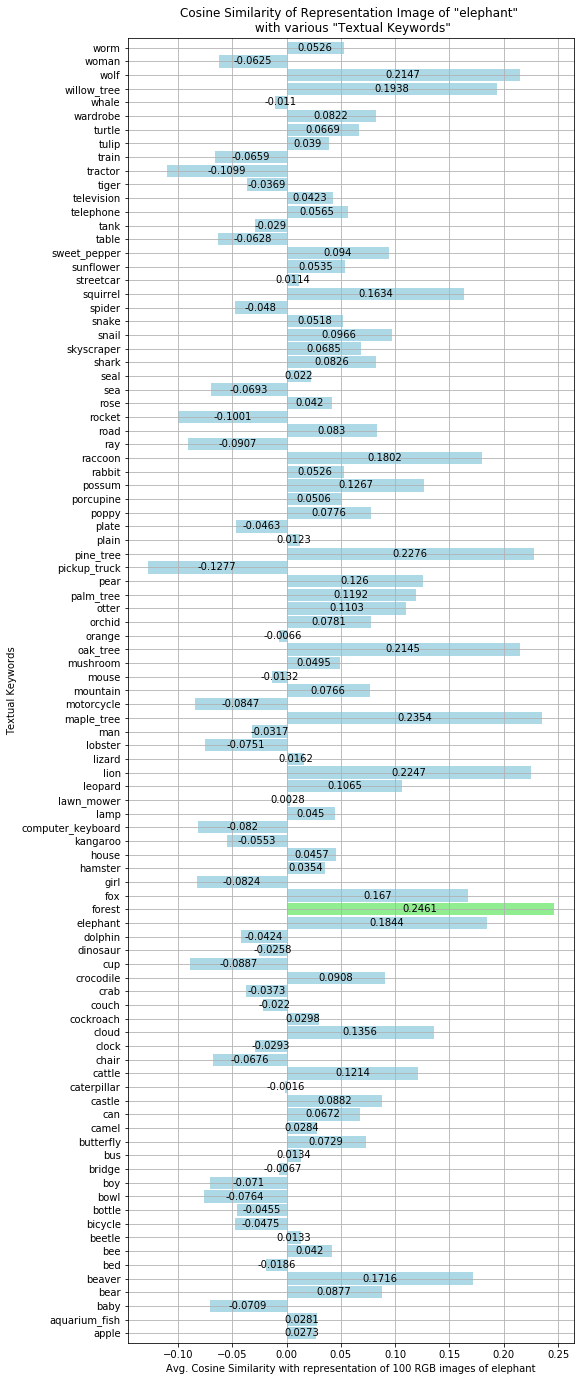

In [467]:
ax = df_result[key]['c_sim_mean'].plot(kind='barh'
                                  , color=colors
                                    ,stacked=True
                             ,figsize=(8,24)
                             ,grid=True,width=0.9
                             ,title='Cosine Similarity of Representation Image of "'+key.split('_')[0]+'" \n with various "Textual Keywords"')

ax.set_xlabel("Avg. Cosine Similarity with representation of 100 RGB images of "+key.split('_')[0])
ax.set_ylabel("Textual Keywords")
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(width), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')